In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
#sns.set(style = 'white', color_code=True)
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape,test.shape
# test.plot(y='LoanAmount',x='Loan_Amount_Term',kind='scatter')

((614, 13), (367, 12))

In [3]:
train['source'] = 'train'
test['source'] = 'test'

In [4]:
data = pd.concat([train,test],ignore_index=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 14 columns):
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
Credit_History       902 non-null float64
Dependents           956 non-null object
Education            981 non-null object
Gender               957 non-null object
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Loan_ID              981 non-null object
Loan_Status          614 non-null object
Married              978 non-null object
Property_Area        981 non-null object
Self_Employed        926 non-null object
source               981 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 115.0+ KB


In [5]:
data.apply(lambda x: sum(x.isnull()))

ApplicantIncome        0
CoapplicantIncome      0
Credit_History        79
Dependents            25
Education              0
Gender                24
LoanAmount            27
Loan_Amount_Term      20
Loan_ID                0
Loan_Status          367
Married                3
Property_Area          0
Self_Employed         55
source                 0
dtype: int64

In [6]:
data['Gender'].fillna('Male',inplace=True)
data['Married'].fillna('Yes',inplace=True)
data['Self_Employed'].fillna('No',inplace=True)
data['Dependents'].fillna('0',inplace=True)
data['Married'].fillna('Yes',inplace=True)
data['Credit_History'].fillna(1.0,inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean(),inplace=True)

impute_grps = data.pivot_table(values=["LoanAmount"], index=["Gender","Married","Self_Employed"], aggfunc=np.mean)

In [7]:
#Create a new function:
def num_missing(x):
  return sum(x.isnull())

#iterate only through rows with missing LoanAmount
for i,row in data.loc[data['LoanAmount'].isnull(),:].iterrows():
    ind = tuple([row['Gender'],row['Married'],row['Self_Employed']])
    data.loc[i,'LoanAmount'] = impute_grps.loc[ind].values[0]

#Now check the #missing values again to confirm:
print(data.apply(num_missing, axis=0))

ApplicantIncome        0
CoapplicantIncome      0
Credit_History         0
Dependents             0
Education              0
Gender                 0
LoanAmount             0
Loan_Amount_Term       0
Loan_ID                0
Loan_Status          367
Married                0
Property_Area          0
Self_Employed          0
source                 0
dtype: int64


In [8]:
data['Total_Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data['Total_Income_log'] = np.log(data['Total_Income'])
#To remove outliers in LoanAmount 
data['LoanAmount_log'] = np.log(data['LoanAmount'])
data['Loan_Amount_Term_log'] = np.log(data['Loan_Amount_Term'])
data['EMI'] = data['LoanAmount_log']/data['Loan_Amount_Term_log']
data['Ratio'] = data['LoanAmount_log']/data['Total_Income_log']
# data['Ratio_here'] = data['Total_Income']/data['LoanAmount']
# data['not_self_graduate_married'] = data.apply(lambda x: 1 if (x['Self_Employed'] == 'No') & (x['Married'] == 'Yes') \
#                                                        & (x['Education'] == 'Graduate' ) & (x['Dependents'] not in ['2','3']) else 0, axis=1)

#data['R_6_Unmarried'] = data.apply(lambda x: 1 if (x['Ratio_here'] > 6) & (x['Married'] == 'No') else 0, axis=1)
# data['male_6000_not_graduate'] = data.apply(lambda x: 1 if (x['ApplicantIncome'] < 6000) & (x['Gender'] == 'Male') & (x['Education'] == 'Not Graduate') else 0, axis=1)
# data['female_self'] = data.apply(lambda x: 1 if (x['Gender'] == 'Female') & (x['Self_Employed'] == 'Yes') else 0, axis=1)

data.drop('ApplicantIncome',axis=1,inplace=True)
data.drop('CoapplicantIncome',axis=1,inplace=True)
data.drop('Gender',axis=1,inplace=True)
data.drop('Self_Employed',axis=1,inplace=True)
data.drop('Total_Income',axis=1,inplace=True)
data.drop('LoanAmount',axis=1,inplace=True)
data.drop('Loan_Amount_Term',axis=1,inplace=True)

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#var_to_encode = ['Dependents','Education','Gender','Married','Property_Area','Self_Employed']
var_to_encode = ['Married','Dependents','Education','Property_Area']
for col in var_to_encode:
    data[col] = le.fit_transform(data[col])

In [10]:
data = pd.get_dummies(data,columns=var_to_encode)

In [11]:
data.head()

,Credit_History,Loan_ID,Loan_Status,source,Total_Income_log,LoanAmount_log,Loan_Amount_Term_log,EMI,Ratio,Married_0,Married_1,Dependents_0,Dependents_1,Dependents_2,Dependents_3,Education_0,Education_1,Property_Area_0,Property_Area_1,Property_Area_2
0,1.0,LP001002,Y,train,8.674026,4.841041,5.886104,0.822452,0.558108,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,LP001003,N,train,8.714568,4.852030,5.886104,0.824319,0.556772,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,LP001005,Y,train,8.006368,4.189655,5.886104,0.711787,0.523290,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,LP001006,Y,train,8.505323,4.787492,5.886104,0.813355,0.562882,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,LP001008,Y,train,8.699515,4.948760,5.886104,0.840753,0.568855,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [12]:
#data['Credit_Score'] = data['Married_1'] + data['Dependents_2'] + data['Education_1'] + data['Property_Area_1'] + data['Property_Area_0']

In [13]:
#data['Credit_History'] = data['Credit_Score'].apply(lambda x : 0.0 if x==1.0 else 1.0)

In [14]:
#data[['Credit_Score','Credit_History']][(data['Credit_History']==0.0) & (data['Credit_Score']==1.0)]

In [15]:
train = data.loc[data['source']=='train']
test = data.loc[data['source']=='test']

In [16]:
train.drop('source',axis=1,inplace=True)
test.drop(['source','Loan_Status'],axis=1,inplace=True)

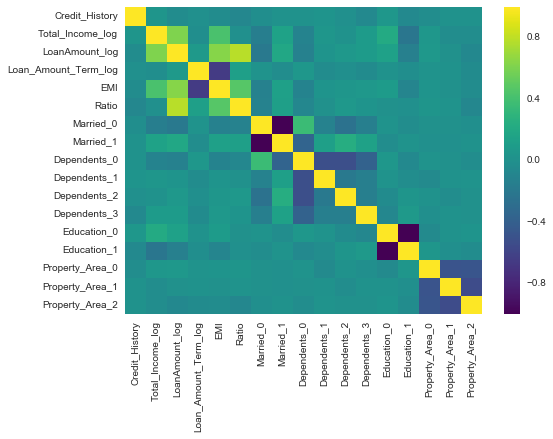

In [17]:
corr_temp = data.corr()
sns.heatmap(corr_temp,cmap='viridis')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 20 columns):
Credit_History          981 non-null float64
Loan_ID                 981 non-null object
Loan_Status             614 non-null object
source                  981 non-null object
Total_Income_log        981 non-null float64
LoanAmount_log          981 non-null float64
Loan_Amount_Term_log    981 non-null float64
EMI                     981 non-null float64
Ratio                   981 non-null float64
Married_0               981 non-null float64
Married_1               981 non-null float64
Dependents_0            981 non-null float64
Dependents_1            981 non-null float64
Dependents_2            981 non-null float64
Dependents_3            981 non-null float64
Education_0             981 non-null float64
Education_1             981 non-null float64
Property_Area_0         981 non-null float64
Property_Area_1         981 non-null float64
Property_Area_2         981 non-null float6

In [19]:
train.to_csv('train_modified27jan.csv',index=False)
test.to_csv('test_modified27jan.csv',index=False)

In [20]:
import pandas as pd 
import pylab
df=pd.read_csv("train.csv")


df["Gender"].fillna(value="other", inplace=True)
df["Genderc"]=df["Gender"].astype("category")
df["Genderc"]=df["Genderc"].cat.rename_categories([1,2,3])
df=df.drop("Gender", axis=1)


df["Married"].fillna(value="No", inplace=True)
df["Marriedc"]=df["Married"].astype("category")
df["Marriedc"]=df["Marriedc"].cat.rename_categories([1,2])
df=df.drop("Married", axis=1)


df["Dependents"].fillna(value="0", inplace=True)
df["Dependentsc"]=df["Dependents"].astype("category")
df["Dependentsc"]=df["Dependentsc"].cat.rename_categories([1,2,3,4])
df=df.drop("Dependents", axis=1)



df["Educationc"]=df["Education"].astype("category")
df["Educationc"]=df["Educationc"].cat.rename_categories([1,2])
df=df.drop("Education", axis=1)



df["Self_Employed"].fillna(value="other", inplace=True)
df["Self_Employedc"]=df["Self_Employed"].astype("category")
df["Self_Employedc"]=df["Self_Employedc"].cat.rename_categories([1,2,3])
df=df.drop("Self_Employed", axis=1)

df["Property_Areac"]=df["Property_Area"].astype("category")
df["Property_Areac"]=df["Property_Areac"].cat.rename_categories([1,2,3])
df=df.drop("Property_Area", axis=1)


df["Credit_History"].fillna(value=1, inplace=True)
df["Credit_Historyc"]=df["Credit_History"].astype("category")
df=df.drop("Credit_History", axis=1)


df["ApplicantIncome"]=df["ApplicantIncome"].astype("object")
df["CoapplicantIncome"]=df["CoapplicantIncome"].astype("object")


df["LoanAmount"]=df["LoanAmount"].fillna(df["LoanAmount"].mean())
df["LoanAmount"]=df["LoanAmount"].astype("object")


df["Loan_Amount_Term"]=df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].mean())
df["Loan_Amount_Term"]=df["Loan_Amount_Term"].astype("object")

from sklearn.preprocessing import scale
e=pd.Series(data=10.5, index=range(0,981))
a = df["LoanAmount"].multiply(9.5*1000)
b=a.multiply(e.pow((df["Loan_Amount_Term"].divide(12))))
d=e.pow((df["Loan_Amount_Term"].divide(12).subtract(1)))
EMI=b.divide(d)

df["sum_Income"]=df["ApplicantIncome"].add(df["CoapplicantIncome"])
df["Poly_feature"]=EMI.divide((df["sum_Income"]))
df["ratio"]=df["sum_Income"].divide(df["LoanAmount"])

df["Poly_feature"]=scale(df["Poly_feature"])
df["sum_Income"]=scale(df["sum_Income"])
df["LoanAmount"]=scale(df["LoanAmount"])
df["Loan_Amount_Term"]=scale(df["Loan_Amount_Term"])
df["ratio"]=scale(df["ratio"])

df_train=df[df.Loan_Status.notnull()]
df_test=df[df.Loan_Status.isnull()]

df_test=df_test.drop("Loan_Status", axis=1)
key=df_test["Loan_ID"]
df_test=df_test.drop("Loan_ID", axis=1)
df_train=df_train.drop("Loan_ID", axis=1)

# from sklearn.preprocessing import OneHotEncoder
# enc=OneHotEncoder()
# Xtrsp=pd.DataFrame(enc.fit_transform(df_train[["Genderc","Marriedc","Dependentsc","Educationc","Self_Employedc","Property_Areac", "Credit_Historyc"]]).\
#                    toarray())
# Xtstsp=pd.DataFrame(enc.transform(df_test[["Genderc","Marriedc","Dependentsc","Educationc","Self_Employedc","Property_Areac", "Credit_Historyc"]]).\
#                     toarray())
# print(Xtrsp.shape)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#var_to_encode = ['Dependents','Education','Gender','Married','Property_Area','Self_Employed']
var_to_encode = ["Genderc","Marriedc","Dependentsc","Educationc","Self_Employedc","Property_Areac", "Credit_Historyc"]
for col in var_to_encode:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])
# df_train = pd.get_dummies(df_train,columns=var_to_encode)
# df_test = pd.get_dummies(df_test,columns=var_to_encode)
df_train["Loan_Statusc"]=df_train["Loan_Status"].astype("category")
df_train["Loan_Statusc"]=df_train["Loan_Statusc"].cat.rename_categories([1,0])


y_train=df_train["Loan_Statusc"]
df_train=df_train.drop("Loan_Status", axis=1)
df_train=df_train.drop("Loan_Statusc", axis=1)




from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
sel = SelectKBest(chi2, k=10)
df_train=pd.DataFrame(sel.fit_transform(df_train,y_train))
df_test=pd.DataFrame(sel.transform(df_test))



df_train_Xtrf=df_train[["Poly_feature","sum_Income","LoanAmount","Loan_Amount_Term","ratio"]]
df_test_Xtstf=df_test[["Poly_feature","sum_Income","LoanAmount","Loan_Amount_Term","ratio"]]

df_train_Xtrf.index=df_train.index
X_train=pd.concat([df_train,df_train_Xtrf], axis=1)
df_test.index=df_test_Xtstf.index
X_test=pd.concat([df_test,df_test_Xtstf], axis=1)

from sklearn.linear_model import LogisticRegression 
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier 
#from sklearn.naive_bayes import GaussianNB
#from sklearn.neural_network import MLPClassifier
#from sklearn.svm import LinearSVC

#model=RandomForestClassifier(n_estimators=128, verbose=1)
model=LogisticRegression(C=0.01, tol=0.00001)
#model=KNeighborsClassifier(n_neighbors=40)
#model=LinearSVC(C=0.01, tol=0.0000001)
#model=GaussianNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(y_pred)

out=pd.DataFrame()
out["Loan_ID"]=key
out["Loan_Status"]=y_pred
out["Loan_Status"]=out["Loan_Status"].astype("category")
out["Loan_Status"]=out["Loan_Status"].cat.rename_categories(["Y","N"])
out.to_csv('outcredit.csv', index=False)






#from sklearn.cross_validation import train_test_split

#Xtr,Xts,ytr,yts=train_test_split(X_train,y_train, test_size=0.1)
#model.fit(Xtr, ytr)
#print model.score(Xts,yts)


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  wa

ValueError: Input X must be non-negative.